# Calculating the $g(\theta)$ of the colloids in the SFD

In [35]:
import pandas as pd
import numpy as np
import scipy.spatial as spa
import matplotlib.pyplot as plt

idx = pd.IndexSlice
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', size=15)

The $g(\theta)$ is defined as the probability of finding another particle at an angle $\theta$ from a particle.

## Load the dataset

We'll use Experiment 1 because that has a high number of particles which will give better statistics. 

In [9]:
trajectory = pd.read_csv("~/Desktop/Experiment1/Experiment1_2018_07_25_09_22_27_trj_recenter.dat",
                         sep="\t",index_col=[0,1])

""" Here we change the string time index to a `datetime` which is sortable"""
trajectory["time"] = pd.to_datetime(trajectory.index.get_level_values("time"))
trajectory["id"] = trajectory.index.get_level_values("id")
trajectory = trajectory.set_index(["time","id"])
trajectory = trajectory.sort_index()

trajectory.head()

/Users/aortiza/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


x           y
time                    id                        
2018-07-25 07:22:27.662 0    -5.668681 -134.209493
                        1   -77.790171 -112.362585
                        2    82.014832 -106.420254
                        3  -125.584088  -43.604495
                        4   129.381068  -41.347869

Experiment 1 was created with an index of timestamps instead of frames. To access them more easily we create an array of all time strings 

In [10]:
times = trajectory.index.get_level_values("time").unique()

Now we calculate the angle $\theta$ with respect to the $x$ axis.

In [11]:
trajectory["theta"] = np.arctan2(trajectory.x,trajectory.y)

We define the angular distance $\Delta\theta$ as described in [SFD Report 1](https://nbviewer.jupyter.org/github/aortiza/Notes/blob/master/SingleFileDiffusion/Single%20File%20Diffusion%20Report%201.ipynb): 

$$\Delta\theta = 
\begin{cases}
\theta_{t+\delta t}-\theta_{t} & \left|\theta_{t+\delta t}-\theta_{t}\right|\leq\pi \\
sign\left(\theta_{t+\delta t}-\theta_{t}\right)\left[2\pi-\left(\theta_{t+\delta t}-\theta_{t}\right)\right] & \left|\theta_{t+\delta t}-\theta_{t}\right|> \pi\\
\end{cases}
$$


In [12]:
def angular_distance(theta1,theta2):
    """Takes two angles and returns the smallest difference between the two."""
    delta = theta1-theta2
    logical = np.abs(delta)>np.pi
    delta[logical] = np.sign(delta[logical])*2*np.pi-delta[logical]
    return delta

We now define a function which takes in the angles in a frame, calculates all the pairwise distances and returns them in a list. This list includes the distances of particles with themselves. They will be removed later. 

In [13]:
def inter_angle_dist(thetas):
    """Takes a Series of angles and returns a list of all the angular distances between the angles"""
    return list(angular_distance(thetas.values.reshape(1,len(thetas)),thetas.values.reshape(len(thetas),1)).flatten())

To save some time, we also define a subset of the trajectory on which we will calculate the angle distances. This is defined as a `slice` so that `times[slice]` returns the times corresponding to the defined subset.

In [14]:
sl = slice(0,len(times),20)

Now we `apply` the function `inter_angle_dist` to each frame.

In [15]:
traj_subset = trajectory.loc[idx[times[sl],:],"theta"]
all_distances_pandas = traj_subset.groupby("time").apply(inter_angle_dist)
all_distances_pandas.head()

time
2018-07-25 07:22:27.662    [0.0, 0.563336341647, 0.698811282173, 1.194393...
2018-07-25 07:22:47.662    [0.0, 0.737332069657, 0.736606895298, 1.195481...
2018-07-25 07:23:07.662    [0.0, 0.645856300015, 0.603763865175, 1.183967...
2018-07-25 07:23:27.662    [0.0, 0.63198224195, 0.574211585085, 1.2310986...
2018-07-25 07:23:47.662    [0.0, 0.541558058452, 0.499230864286, 1.155067...
Name: theta, dtype: object

This last cell produced a pandas series with a list of distances for each frame. We need to flatten this to a simple list of distances. This is done in a numpy array since there is no longer need for an index

In [16]:
all_distances = np.array([dist for dist_at_t in all_distances_pandas[:] for dist in dist_at_t])

Now we create a mask to delete all the zeros in the array.

In [17]:
mask = np.ones(np.shape(all_distances), dtype=bool)
mask[all_distances==0] = False

all_distances = all_distances[mask]

Then we only need to take the histogram of the `all_distances` array.

Text(0.5,0,'$\\Delta \\theta$ [rad]')

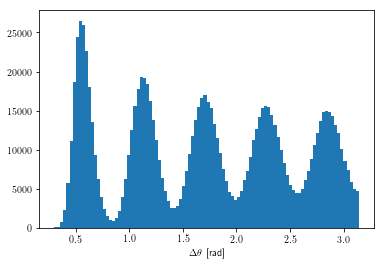

In [18]:
H = plt.hist(abs(np.array(all_distances)),bins=100)
plt.xlabel(r"$\Delta \theta$ [rad]")

We save this in a dataframe.

In [19]:
H = np.histogram(abs(np.array(all_distances)),bins=np.linspace(0,np.pi,100))

In [20]:
g_of_theta = pd.DataFrame(data=H[0]/len(times[sl]),index=(H[1][0:-1]+H[1][1:])/2,columns=["Exp_1"])
g_of_theta.index.name="theta"

Text(0,0.5,'$g(\\theta)$')

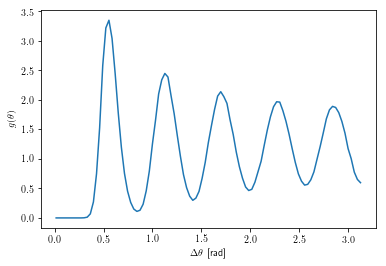

In [21]:
plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

In [22]:
g_of_theta.head()

,Exp_1
theta,
0.015867,0.0
0.047600,0.0
0.079333,0.0
0.111066,0.0
0.142800,0.0


# Rest of the experiments

We'll define this as a function to apply it to the rest of the experiments

In [25]:
def calculate_g_of_theta(trajectory, sampling = 1, theta_out = None, col_name = ""):
    """Takes in a trajectory, and returns a pandas array with the probability of finding a particle at a given angle"""
    
    trajectory["theta"] = np.arctan2(trajectory.x,trajectory.y)
    
    def angular_distance(theta1,theta2):
        """Takes two angles and returns the smallest difference between the two."""
        delta = theta1-theta2
        logical = np.abs(delta)>np.pi
        delta[logical] = np.sign(delta[logical])*2*np.pi-delta[logical]
        return delta

    def inter_angle_dist(thetas):
        """Takes a Series of angles and returns a list of all the angular distances between the angles"""
        return list(angular_distance(thetas.values.reshape(1,len(thetas)),
                                     thetas.values.reshape(len(thetas),1)).flatten())


    frames = trajectory.index.get_level_values("frame").unique()
    
    sl = slice(0,len(frames),sampling)
    traj_subset = trajectory.loc[idx[frames[sl],:],"theta"]
    all_distances_pandas = traj_subset.groupby("frame").apply(inter_angle_dist)
    all_distances_pandas.head()
    
    all_distances = np.array([dist for dist_at_t in all_distances_pandas[:] for dist in dist_at_t])
    
    mask = np.ones(np.shape(all_distances), dtype=bool)
    mask[all_distances==0] = False

    all_distances = all_distances[mask]
    
    H = np.histogram(abs(np.array(all_distances)),bins=theta_out)
    g_of_theta = pd.DataFrame(data=H[0]/len(frames[sl]),index=(H[1][0:-1]+H[1][1:])/2,columns=[col_name])

    g_of_theta.index.name="theta"
    return g_of_theta

/Users/aortiza/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


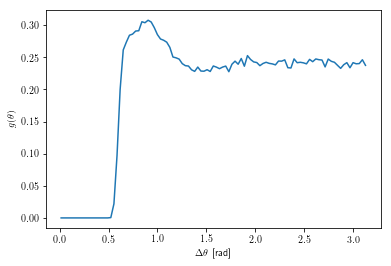

In [26]:
trajectory = pd.read_csv("~/Desktop/Experiment8/Experiment8_2018_09_17_16_58_33_trj.dat",
                         sep="\t",index_col=[0,1])
trajectory = trajectory.sort_index()

g_of_theta8 = calculate_g_of_theta(trajectory, 
                                   sampling = 10, theta_out = np.linspace(0,np.pi,100), col_name = "Exp_8")

plt.plot(g_of_theta8)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

g_of_theta = g_of_theta.assign(Exp_8 = g_of_theta8.Exp_8)


/Users/aortiza/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


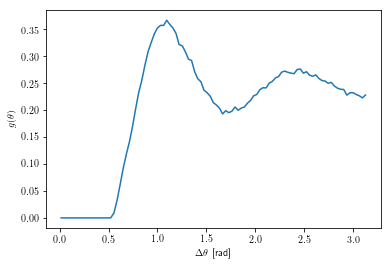

In [27]:
trajectory = pd.read_csv("~/Desktop/Experiment9/Experiment9_2018_09_21_15_37_26_trj.dat",
                         sep="\t",index_col=[0,1])
trajectory = trajectory.sort_index()

g_of_theta9 = calculate_g_of_theta(trajectory, 
                                   sampling = 10, theta_out = np.linspace(0,np.pi,100), col_name = "Exp_9")

plt.plot(g_of_theta9)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

g_of_theta = g_of_theta.assign(Exp_9 = g_of_theta9.Exp_9)


/Users/aortiza/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


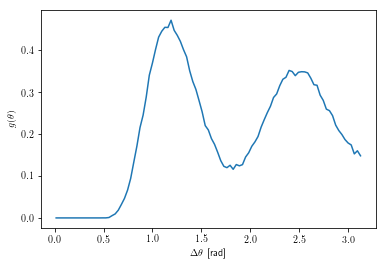

In [28]:
trajectory = pd.read_csv("~/Desktop/Experiment10/Experiment10_2018_09_25_10_39_13_trj.dat",
                         sep="\t",index_col=[0,1])
trajectory = trajectory.sort_index()

g_of_theta10 = calculate_g_of_theta(trajectory, 
                                   sampling = 10, theta_out = np.linspace(0,np.pi,100), col_name = "Exp_10")

plt.plot(g_of_theta10)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

g_of_theta = g_of_theta.assign(Exp_10 = g_of_theta10.Exp_10)

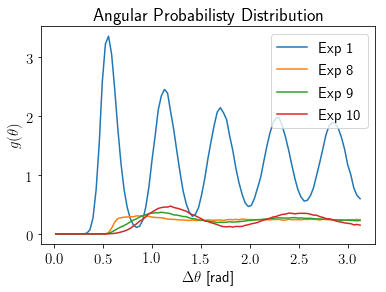

In [40]:
plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")
plt.legend(["Exp 1","Exp 8","Exp 9","Exp 10"],loc=1)
plt.title("Angular Probabilisty Distribution");

In [30]:
g_of_theta.head()

,Exp_1,Exp_8,Exp_9,Exp_10
theta,,,,
0.015867,0.0,0.0,0.0,0.0
0.047600,0.0,0.0,0.0,0.0
0.079333,0.0,0.0,0.0,0.0
0.111066,0.0,0.0,0.0,0.0
0.142800,0.0,0.0,0.0,0.0


In [31]:
g_of_theta.to_csv("/Users/aortiza/Desktop/g_of_theta.dat",sep="\t")